# Baseline Model using Opcode N Grams 

## Set up

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


In [3]:
PATH = Path.cwd().parents[2]
DATA_PATH = os.path.join(PATH, 'data/processed/ir_gigahorse')

## List Traditional ML model to compare

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

models = {
  # MultiOutputClassifier Wrappers
  "MultiOutputClassifier(LogisticRegression())": MultiOutputClassifier(LogisticRegression()),
  "MultiOutputClassifier(DecisionTreeClassifier())": MultiOutputClassifier(DecisionTreeClassifier()),
  "MultiOutputClassifier(RandomForestClassifier())": MultiOutputClassifier(RandomForestClassifier()),
  "MultiOutputClassifier(AdaBoostClassifier())": MultiOutputClassifier(AdaBoostClassifier()),
  "MultiOutputClassifier(ExtraTreesClassifier())": MultiOutputClassifier(ExtraTreesClassifier()),
  "MultiOutputClassifier(XGBClassifier())": MultiOutputClassifier(XGBClassifier()),
  "MultiOutputClassifier(LGBMClassifier())": MultiOutputClassifier(LGBMClassifier()),
  "MultiOutputClassifier(SVC())": MultiOutputClassifier(SVC()),
  "MultiOutputClassifier(GaussianNB())": MultiOutputClassifier(GaussianNB()),
  "MultiOutputClassifier(KNeighborsClassifier())": MultiOutputClassifier(KNeighborsClassifier()),
  "MultiOutputClassifier(SGDClassifier())": MultiOutputClassifier(SGDClassifier()),
  "MultiOutputClassifier(MLPClassifier())": MultiOutputClassifier(MLPClassifier()),

  # OneVsRestClassifier Wrappers
  "OneVsRestClassifier(LogisticRegression())": OneVsRestClassifier(LogisticRegression()),
  "OneVsRestClassifier(DecisionTreeClassifier())": OneVsRestClassifier(DecisionTreeClassifier()),
  "OneVsRestClassifier(RandomForestClassifier())": OneVsRestClassifier(RandomForestClassifier()),
  "OneVsRestClassifier(AdaBoostClassifier())": OneVsRestClassifier(AdaBoostClassifier()),
  "OneVsRestClassifier(ExtraTreesClassifier())": OneVsRestClassifier(ExtraTreesClassifier()),
  "OneVsRestClassifier(XGBClassifier())": OneVsRestClassifier(XGBClassifier()),
  "OneVsRestClassifier(LGBMClassifier())": OneVsRestClassifier(LGBMClassifier()),
  "OneVsRestClassifier(SVC())": OneVsRestClassifier(SVC()),
  "OneVsRestClassifier(GaussianNB())": OneVsRestClassifier(GaussianNB()),
  "OneVsRestClassifier(KNeighborsClassifier())": OneVsRestClassifier(KNeighborsClassifier()),
  "OneVsRestClassifier(SGDClassifier())": OneVsRestClassifier(SGDClassifier()),
  "OneVsRestClassifier(MLPClassifier())": OneVsRestClassifier(MLPClassifier()),
}

## Load Dataset

In [5]:
df = pd.read_csv(os.path.join(DATA_PATH, 'n_grams_dataset.csv')).set_index('address')
grouping_df = pd.read_csv(os.path.join(DATA_PATH, 'grouping_n_grams_dataset.csv')).set_index('address')

with open(os.path.join(DATA_PATH, 'n_grams_features.json'), "r") as f:
    features = json.load(f)

with open(os.path.join(DATA_PATH, 'grouping_n_grams_features.json'), "r") as f:
    grouping_features = json.load(f)

with open(os.path.join(DATA_PATH, 'labels.json'), "r") as f:
    labels = json.load(f)

In [6]:
df.head()

,mint,leak,limit,add add,add and,add and dup3,add calldataload,add calldataload push2,add dup1,add dup1 dup1,...,swap3 swap2,swap3 swap2 pop,swap3 swap2 swap1,swap4 pop,swap4 pop pop,swap4 swap1,swap4 swap1 swap4,swap4 swap3,swap4 swap3 pop,swap5 pop
address,,,,,,,,,,,,,,,,,,,,,
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,3,0,0,2,0,1,0,...,4,2,2,3,3,3,2,2,2,0
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0,0,4,3,0,0,2,0,...,26,25,1,5,3,0,0,3,2,2
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1,4,4,3,1,0,3,0,...,40,37,3,9,6,0,0,7,4,0
0x11cbc781dadaad13fc3a361772c80b1c027820af,0,0,0,1,4,4,3,0,8,0,...,4,1,1,2,1,4,3,5,3,3


In [7]:
grouping_df.head()

,mint,leak,limit,add add,add add mstore,add add swap,add and,add and dup,add calldataload,add calldataload push,...,swap swap div,swap swap dup,swap swap mstore,swap swap or,swap swap pop,swap swap push,swap swap sha,swap swap sstore,swap swap swap,timestamp push
address,,,,,,,,,,,,,,,,,,,,,
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,3,0,3,0,0,2,0,...,0,2,5,3,10,6,3,2,14,0
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0,0,0,0,4,3,0,0,...,0,0,0,0,52,54,0,0,2,0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1,4,0,2,4,3,1,1,...,0,0,0,0,84,73,0,0,14,2
0x11cbc781dadaad13fc3a361772c80b1c027820af,0,0,0,1,1,0,4,4,3,0,...,0,2,7,5,15,14,3,5,24,2


In [8]:
features[:5]

['add add',
 'add and',
 'add and dup3',
 'add calldataload',
 'add calldataload push2']

In [9]:
grouping_features[:5]

['add add', 'add add mstore', 'add add swap', 'add and', 'add and dup']

In [10]:
labels[:5]

['mint', 'leak', 'limit']

## Prepare Features and Labels

In [11]:
X = df[features]
grouping_X = grouping_df[grouping_features]
y = df[labels]
grouping_y = df[labels]

## Train/Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

grouping_X_train, grouping_X_test, grouping_y_train, grouping_y_test = train_test_split(
    grouping_X, grouping_y, test_size=0.2, random_state=42
)

## Run all models and collect reports

In [13]:
def get_report_all_ml(X_train, y_train, X_test, y_test):
    report_list = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Generate classification report (as dict)
        report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        # Average scores across all labels (macro average)
        avg_scores = report_dict["macro avg"]

        report_list.append({
            "Model": name,
            "Precision": avg_scores["precision"],
            "Recall": avg_scores["recall"],
            "F1-score": avg_scores["f1-score"]
        })

    df_report = pd.DataFrame(report_list)
    df_report = df_report.sort_values("F1-score", ascending=False).reset_index(drop=True)

    return df_report

## Show report

In [14]:
def display_multilabel_confusion_matrix(y_test, y_pred):
    # Ensure y_test and y_pred are binary numeric arrays
    y_test_array = np.array(y_test, dtype=int)
    y_pred_array = np.array(y_pred, dtype=int)

    # Generate multi-label confusion matrix again using numeric arrays
    conf_matrices_fixed = multilabel_confusion_matrix(y_test_array, y_pred_array)

    # Plot each confusion matrix again to confirm it's fixed
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for i, (cm, label) in enumerate(zip(conf_matrices_fixed, y.columns)):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix: {label}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

In [15]:
df_report = get_report_all_ml(X_train, y_train, X_test, y_test)
df_report

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17, number of negative: 36
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6311
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 724
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.320755 -> initscore=-0.750306
[LightGBM] [Info] Start training from score -0.750306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

,Model,Precision,Recall,F1-score
0,OneVsRestClassifier(MLPClassifier()),0.611111,0.607143,0.520202
1,MultiOutputClassifier(LogisticRegression()),0.527778,0.654762,0.500855
2,OneVsRestClassifier(LogisticRegression()),0.527778,0.654762,0.500855
3,MultiOutputClassifier(XGBClassifier()),0.500000,0.654762,0.497354
4,OneVsRestClassifier(XGBClassifier()),0.500000,0.654762,0.497354
5,OneVsRestClassifier(LGBMClassifier()),0.470238,0.654762,0.481481
6,MultiOutputClassifier(LGBMClassifier()),0.470238,0.654762,0.481481
7,MultiOutputClassifier(DecisionTreeClassifier()),0.414683,0.654762,0.465608
8,MultiOutputClassifier(MLPClassifier()),0.583333,0.559524,0.444444
9,OneVsRestClassifier(AdaBoostClassifier()),0.511905,0.559524,0.441077


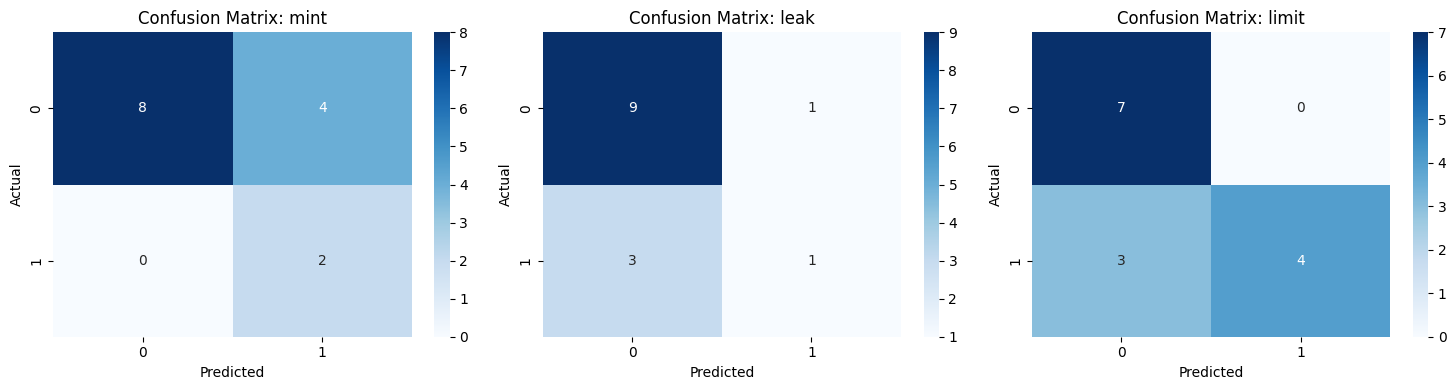

In [16]:
best_model = models[df_report['Model'][0]]
y_pred = best_model.predict(X_test)

display_multilabel_confusion_matrix(y_test, y_pred)

In [17]:
labels = y.columns.tolist()  # assuming y is a pandas DataFrame

for i, label in enumerate(labels):
    report_dict = classification_report(y_test[label], y_pred[:, i], output_dict=True)
    f1 = report_dict["macro avg"]["f1-score"]
    print(f"{label}, f1-score: {f1}")

mint, f1-score: 0.65
leak, f1-score: 0.5757575757575758
limit, f1-score: 0.7754010695187166


In [18]:
df_report = get_report_all_ml(grouping_X_train, grouping_y_train, grouping_X_test, grouping_y_test)
df_report

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17, number of negative: 36
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5554
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 608
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.320755 -> initscore=-0.750306
[LightGBM] [Info] Start training from score -0.750306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

,Model,Precision,Recall,F1-score
0,MultiOutputClassifier(LogisticRegression()),0.611111,0.702381,0.585470
1,OneVsRestClassifier(LogisticRegression()),0.611111,0.702381,0.585470
2,OneVsRestClassifier(AdaBoostClassifier()),0.528571,0.690476,0.537037
3,MultiOutputClassifier(AdaBoostClassifier()),0.528571,0.690476,0.537037
4,OneVsRestClassifier(DecisionTreeClassifier()),0.482540,0.654762,0.523810
5,MultiOutputClassifier(DecisionTreeClassifier()),0.428571,0.702381,0.493386
6,MultiOutputClassifier(MLPClassifier()),0.380952,0.619048,0.433862
7,MultiOutputClassifier(RandomForestClassifier()),0.341667,0.571429,0.412698
8,OneVsRestClassifier(RandomForestClassifier()),0.355556,0.523810,0.395604
9,OneVsRestClassifier(SVC()),0.355556,0.523810,0.395604


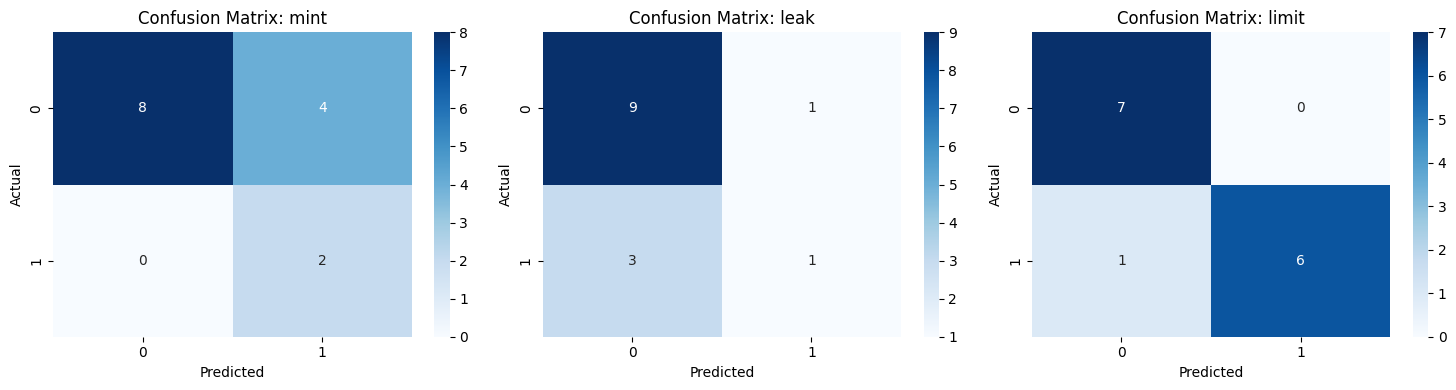

In [19]:
best_model = models[df_report['Model'][0]]
y_pred = best_model.predict(grouping_X_test)

display_multilabel_confusion_matrix(grouping_y_test, y_pred)

In [20]:
labels = y.columns.tolist()  # assuming y is a pandas DataFrame

for i, label in enumerate(labels):
    report_dict = classification_report(grouping_y_test[label], y_pred[:, i], output_dict=True)
    f1 = report_dict["macro avg"]["f1-score"]
    print(f"{label}, f1-score: {f1}")

mint, f1-score: 0.65
leak, f1-score: 0.5757575757575758
limit, f1-score: 0.9282051282051282


## MLP

### Build model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError

2025-07-15 12:12:05.753646: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
def Model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.4),

        Dense(256, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # sigmoid for multi-label
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-6),
        metrics=['accuracy']
    )
    return model

In [23]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])

In [24]:
grouping_model = Model(input_dim=grouping_X.shape[1], output_dim=y.shape[1])

### Train

In [25]:
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - accuracy: 0.4945 - loss: 0.6985 - val_accuracy: 0.8182 - val_loss: 1.2968 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4053 - loss: 0.7928 - val_accuracy: 0.8182 - val_loss: 1.0398 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5263 - loss: 0.7780 - val_accuracy: 0.8182 - val_loss: 0.9610 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4211 - loss: 0.7573 - val_accuracy: 0.8182 - val_loss: 0.9023 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3790 - loss: 0.7564 - val_accuracy: 0.8182 - val_loss: 0.8647 - learning_rate: 1.0000e-06
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4157 - loss: 0.7622 - val_accuracy: 0.8182 - val_loss: 0.8294 - learning_rate: 1.0000e-06
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4737 - loss

In [26]:
grouping_model.fit(grouping_X_train, grouping_y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - accuracy: 0.3686 - loss: 0.6809 - val_accuracy: 0.0000e+00 - val_loss: 2.6952 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4157 - loss: 0.7401 - val_accuracy: 0.0000e+00 - val_loss: 2.1748 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5635 - loss: 0.6533 - val_accuracy: 0.0000e+00 - val_loss: 1.8521 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3686 - loss: 0.7202 - val_accuracy: 0.0000e+00 - val_loss: 1.6869 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4474 - loss: 0.7367 - val_accuracy: 0.0000e+00 - val_loss: 1.5286 - learning_rate: 1.0000e-06
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4896 - loss: 0.6590 - val_accuracy: 0.0000e+00 - val_loss: 1.4062 - learning_rate: 1.0000e-06
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step -

### Predict

In [27]:
y_test_prob = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


In [28]:
def tune_thresholds(y_true, y_pred_prob, metric='f1'):
    y_true = np.asarray(y_true)          # Fix: convert to NumPy
    y_pred_prob = np.asarray(y_pred_prob)

    best_thresholds = []
    best_scores = []

    for i in range(y_true.shape[1]):
        label_true = y_true[:, i]
        label_probs = y_pred_prob[:, i]  # Fix here too

        thresholds = np.linspace(0.0, 1.0, 101)
        scores = []

        for t in thresholds:
            label_pred = (label_probs >= t).astype(int)
            if metric == 'f1':
                score = f1_score(label_true, label_pred, zero_division=0)
            scores.append(score)

        best_t = thresholds[np.argmax(scores)]
        best_score = np.max(scores)

        best_thresholds.append(best_t)
        best_scores.append(best_score)

        print(f"Label {i}: Best threshold = {best_t:.2f}, Best {metric} = {best_score:.4f}")

    return best_thresholds, best_scores


In [29]:
best_thresholds, _ = tune_thresholds(y_test, y_test_prob)

Label 0: Best threshold = 0.38, Best f1 = 0.2667
Label 1: Best threshold = 0.00, Best f1 = 0.4444
Label 2: Best threshold = 0.02, Best f1 = 0.7000


In [30]:
y_pred = (model.predict(X_test) >= best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [31]:
grouping_y_test_prob = grouping_model.predict(grouping_X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


In [32]:
grouping_best_thresholds, _ = tune_thresholds(grouping_y_test, grouping_y_test_prob)

Label 0: Best threshold = 0.42, Best f1 = 0.5000
Label 1: Best threshold = 0.46, Best f1 = 0.6000
Label 2: Best threshold = 0.36, Best f1 = 0.7778


In [33]:
grouping_y_pred = (grouping_model.predict(grouping_X_test) >= grouping_best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


### Report

In [34]:
print(classification_report(y_test, y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.15      1.00      0.27         2
        leak       0.29      1.00      0.44         4
       limit       0.54      1.00      0.70         7

   micro avg       0.33      1.00      0.49        13
   macro avg       0.33      1.00      0.47        13
weighted avg       0.40      1.00      0.55        13
 samples avg       0.32      0.64      0.42        13



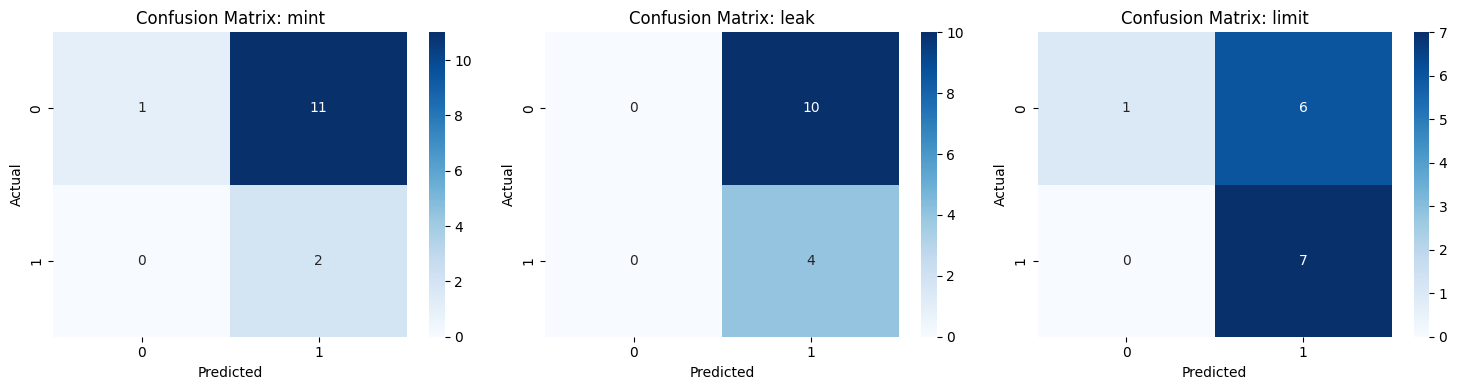

In [35]:
display_multilabel_confusion_matrix(y_test, y_pred)

In [36]:
print(classification_report(grouping_y_test, grouping_y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.33      1.00      0.50         2
        leak       0.50      0.75      0.60         4
       limit       0.64      1.00      0.78         7

   micro avg       0.52      0.92      0.67        13
   macro avg       0.49      0.92      0.63        13
weighted avg       0.55      0.92      0.68        13
 samples avg       0.49      0.57      0.51        13



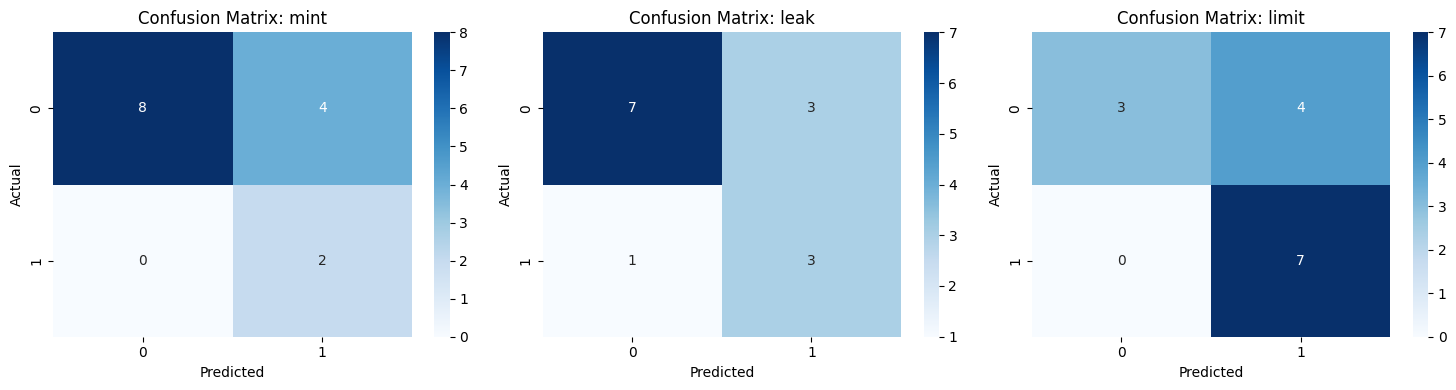

In [37]:
display_multilabel_confusion_matrix(grouping_y_test, grouping_y_pred)

## Autoencoder + MPL

In [38]:
def Autoencoder(input_dim=256):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128),
        LeakyReLU(0.01),

        Dense(32),
        BatchNormalization(),
        LeakyReLU(0.01),

        Dense(128),
        BatchNormalization(),
        LeakyReLU(0.01),

        Dense(input_dim, activation='sigmoid')  # sigmoid for multi-label
    ])

    model.compile(optimizer=Adam(1e-6), loss=MeanSquaredError())
    return model


In [39]:
autoencoder = Autoencoder(input_dim=X.shape[1])
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 404.1177 - val_loss: 276.6338
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 384.8533 - val_loss: 276.6254
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 393.5588 - val_loss: 276.6216
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 378.8177 - val_loss: 276.6210
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 403.5324 - val_loss: 276.6218
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 381.0190 - val_loss: 276.6233
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 397.7085 - val_loss: 276.6248
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 369.2689 - val_loss: 276.6265
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 377.9165 - val_loss: 276.6287
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 392.2038 - val_loss: 276.6299
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 369.1588 - val_loss: 276.6324
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [40]:
grouping_autoencoder = Autoencoder(input_dim=grouping_X.shape[1])
grouping_autoencoder.fit(grouping_X_train, grouping_X_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 615.9898 - val_loss: 459.8968
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 631.0537 - val_loss: 459.8209
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 681.9759 - val_loss: 459.7809
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 644.9016 - val_loss: 459.7482
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 632.3986 - val_loss: 459.7226
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 672.2375 - val_loss: 459.7033
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 682.4244 - val_loss: 459.6905
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 663.3284 - val_loss: 459.6772
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 633.4225 - val_loss: 459.6678
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 627.6555 - val_loss: 459.6577
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 622.2823 - val_loss: 459.6483
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [41]:
X_train_encoded = autoencoder.predict(X_train)
X_test_encoded = autoencoder.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [42]:
grouping_X_train_encoded = grouping_autoencoder.predict(grouping_X_train)
grouping_X_test_encoded = grouping_autoencoder.predict(grouping_X_test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x13b76ea20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [43]:
model = Model(input_dim=X_train_encoded.shape[1], output_dim=y.shape[1])

In [44]:
grouping_model = Model(input_dim=grouping_X_train_encoded.shape[1], output_dim=grouping_y.shape[1])

In [45]:
model.fit(X_train_encoded, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step - accuracy: 0.1736 - loss: 0.9258 - val_accuracy: 0.0000e+00 - val_loss: 0.8528 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.1632 - loss: 0.9180 - val_accuracy: 0.0000e+00 - val_loss: 0.8511 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.1106 - loss: 0.9338 - val_accuracy: 0.0000e+00 - val_loss: 0.8486 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.1106 - loss: 0.8908 - val_accuracy: 0.0000e+00 - val_loss: 0.8462 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.1632 - loss: 0.9261 - val_accuracy: 0.0000e+00 - val_loss: 0.8436 - learning_rate: 1.0000e-06
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.1632 - loss: 0.9187 - val_accuracy: 0.0000e+00 - val_loss: 0.8411 - learning_rate: 1.0000e-06
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/

In [46]:
grouping_model.fit(grouping_X_train_encoded, grouping_y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - accuracy: 0.4792 - loss: 0.9380 - val_accuracy: 0.8182 - val_loss: 0.6395 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3948 - loss: 0.9393 - val_accuracy: 0.8182 - val_loss: 0.6417 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3318 - loss: 0.8167 - val_accuracy: 0.8182 - val_loss: 0.6439 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4841 - loss: 0.9453 - val_accuracy: 0.8182 - val_loss: 0.6469 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3001 - loss: 0.8904 - val_accuracy: 0.8182 - val_loss: 0.6482 - learning_rate: 1.0000e-06
Epoch 6/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4062 - loss: 0.8488
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4053 - loss: 0.84

In [47]:
y_pred_prob = model.predict(X_test_encoded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


In [48]:
grouping_y_pred_prob = grouping_model.predict(grouping_X_test_encoded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


In [49]:
best_thresholds, _ = tune_thresholds(y_test, y_test_prob)

Label 0: Best threshold = 0.38, Best f1 = 0.2667
Label 1: Best threshold = 0.00, Best f1 = 0.4444
Label 2: Best threshold = 0.02, Best f1 = 0.7000


In [50]:
grouping_best_thresholds, _ = tune_thresholds(grouping_y_test, grouping_y_test_prob)

Label 0: Best threshold = 0.42, Best f1 = 0.5000
Label 1: Best threshold = 0.46, Best f1 = 0.6000
Label 2: Best threshold = 0.36, Best f1 = 0.7778


In [51]:
y_pred = (model.predict(X_test) >= best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


In [52]:
grouping_y_pred = (grouping_model.predict(grouping_X_test) >= grouping_best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


### Report

In [53]:
print(classification_report(y_test, y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.20      0.50      0.29         2
        leak       0.29      1.00      0.44         4
       limit       0.50      0.86      0.63         7

   micro avg       0.35      0.85      0.50        13
   macro avg       0.33      0.79      0.45        13
weighted avg       0.39      0.85      0.52        13
 samples avg       0.38      0.57      0.43        13



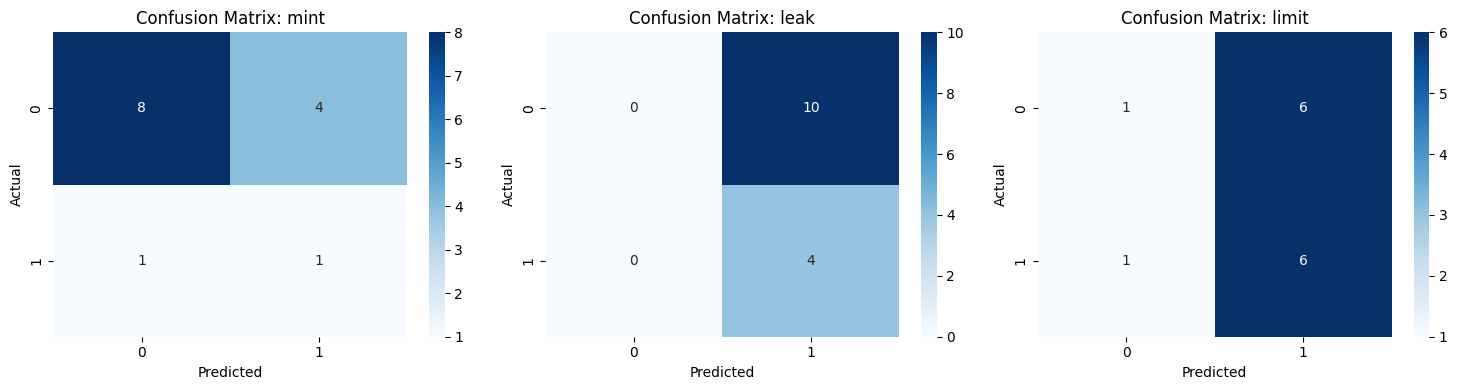

In [54]:
display_multilabel_confusion_matrix(y_test, y_pred)

In [55]:
print(classification_report(grouping_y_test, grouping_y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.20      1.00      0.33         2
        leak       0.20      0.25      0.22         4
       limit       0.50      0.43      0.46         7

   micro avg       0.29      0.46      0.35        13
   macro avg       0.30      0.56      0.34        13
weighted avg       0.36      0.46      0.37        13
 samples avg       0.15      0.25      0.19        13



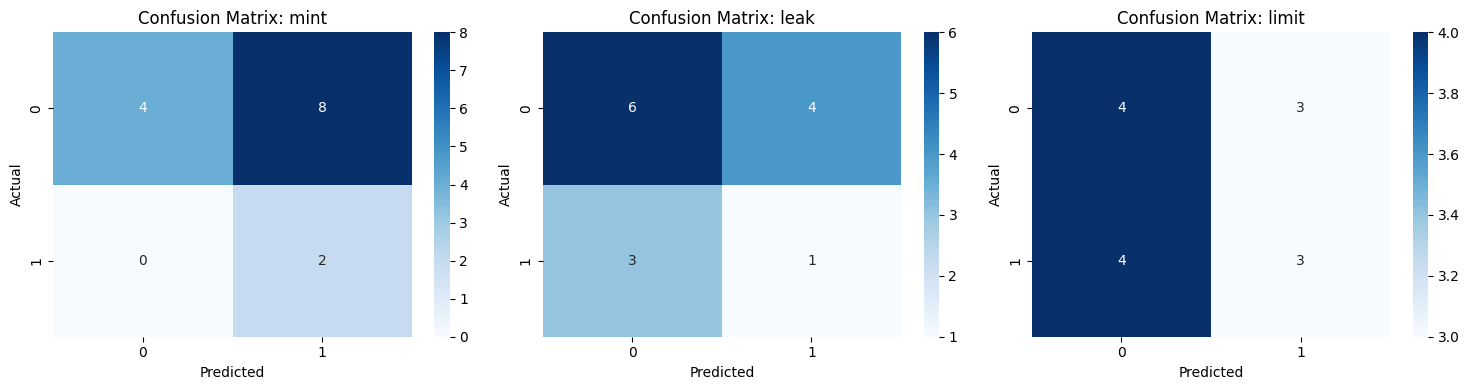

In [56]:
display_multilabel_confusion_matrix(grouping_y_test, grouping_y_pred)